In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage.filters import threshold_local
from PIL import Image
Image.__version__ #needs to be below or 9.5.0 as above that "ANTIALIAS" wont work

'9.5.0'

/tmp/ipykernel_3200/1530759598.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


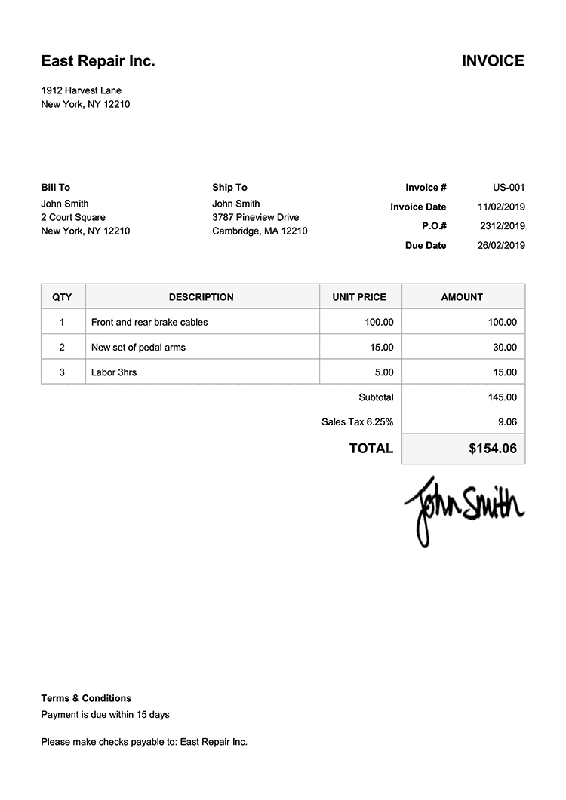

In [4]:
#loading image
file_name = '/teamspace/studios/this_studio/images/invoice.png'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [5]:
def resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [6]:
def rgb_conv(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))# convert BGR to RGB matrix correction in short

In [7]:
def grey_conv(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')#cmap is color mapping

In [8]:
image = cv2.imread(file_name)
resize_ratio = 1000 / image.shape[0]
original = image.copy()
image = resize(image, resize_ratio)

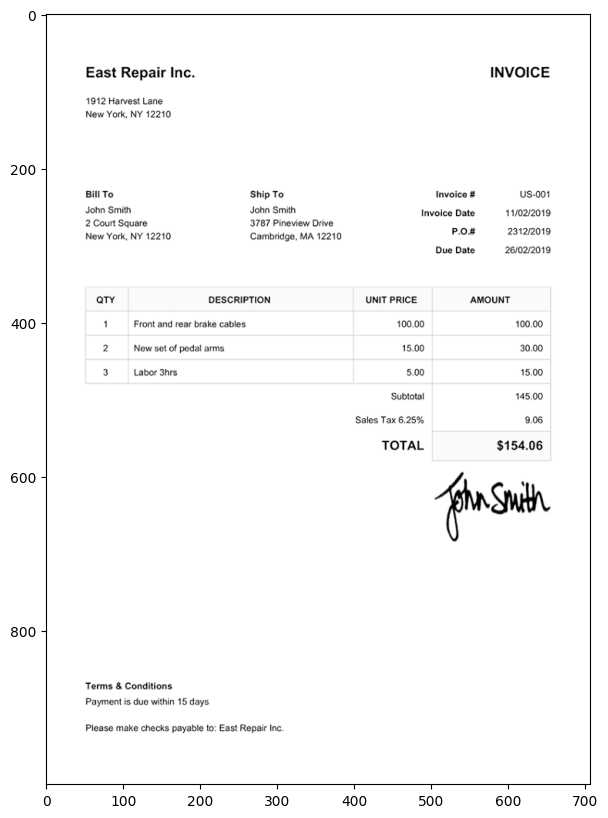

In [9]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grey_conv(gray)

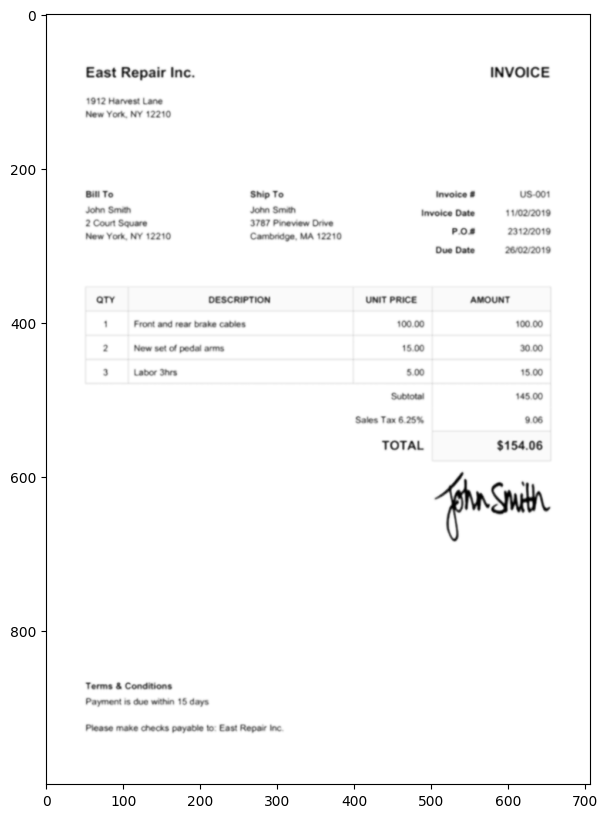

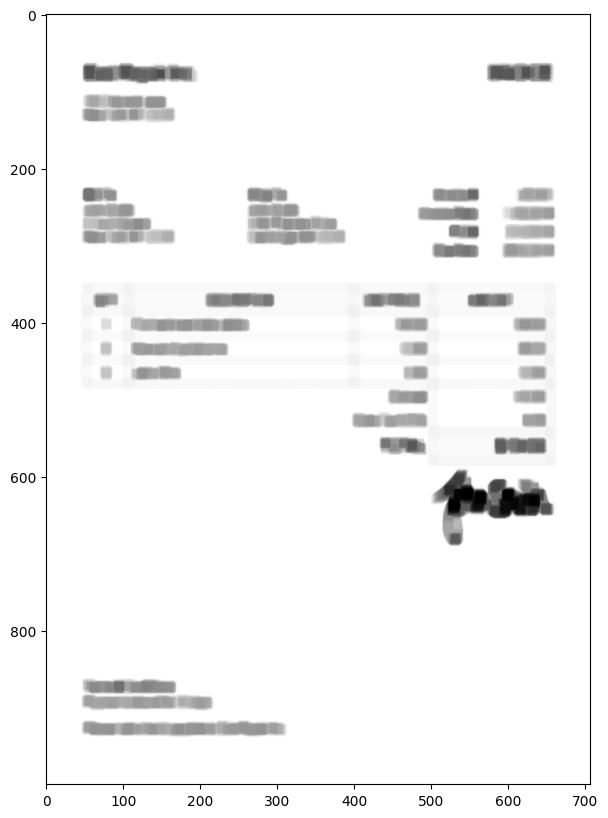

In [10]:
#gaussian blurring technique
blur = cv2.GaussianBlur(gray, (5, 5), 1)
grey_conv(blur)
blur = cv2.medianBlur(blur,7)

#focusing upon the text and image elements
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blur,kernel,iterations = 1)
grey_conv(erosion)

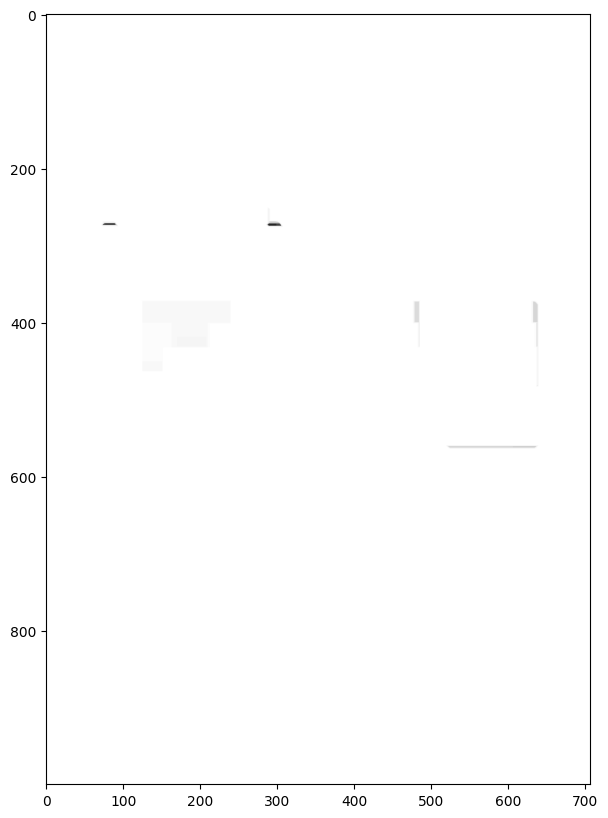

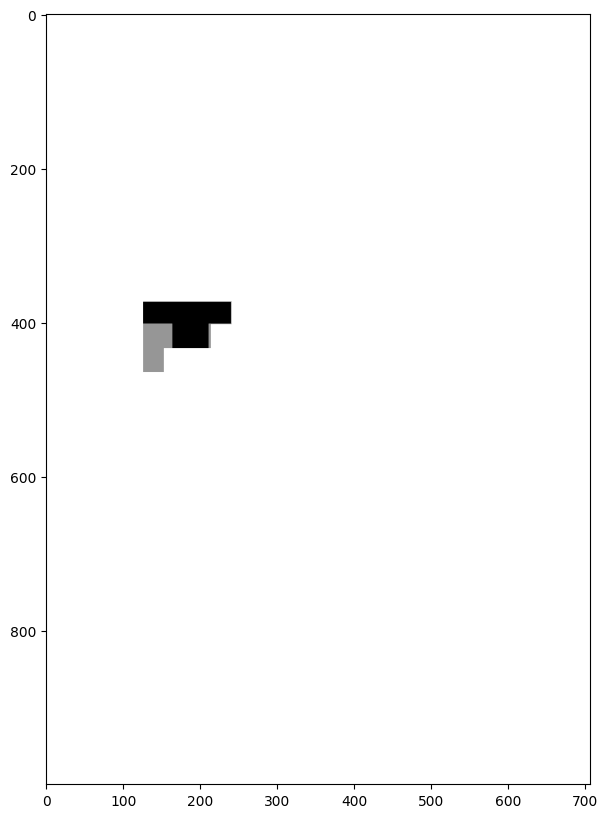

In [11]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernelv2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)
grey_conv(dilated)

opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernelv2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernelv2)

grey_conv(closing)

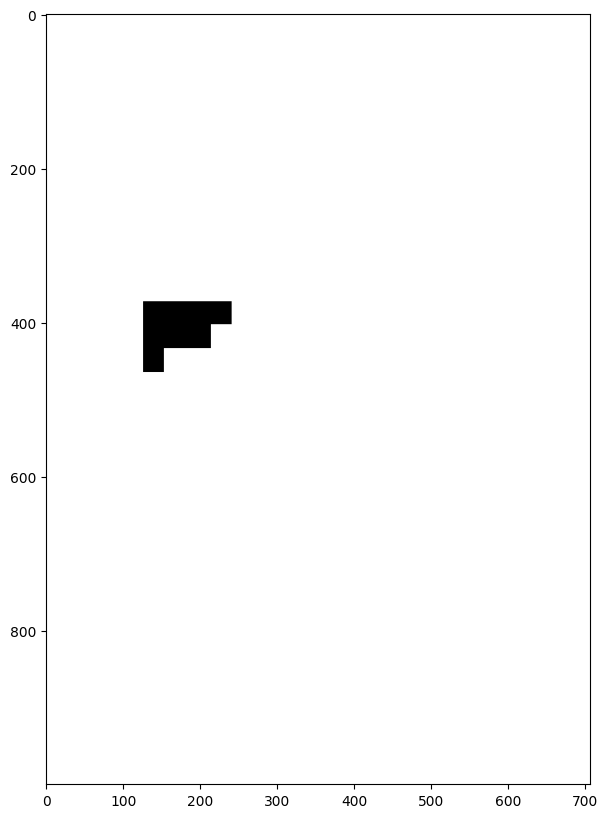

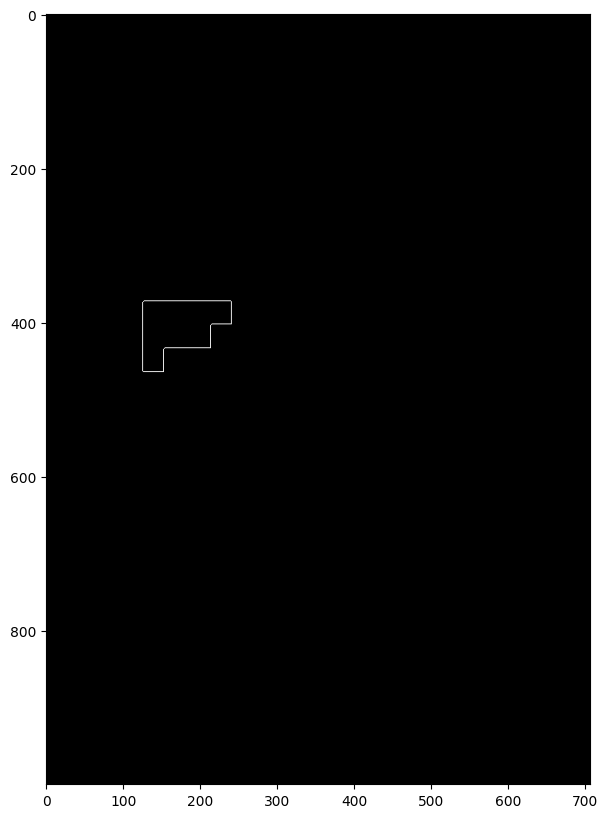

In [12]:
#b_w_image = black and white images
(thresh, b_w_image) = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
grey_conv(b_w_image)

edged = cv2.Canny(b_w_image, 30, 30, apertureSize=3)
grey_conv(edged)

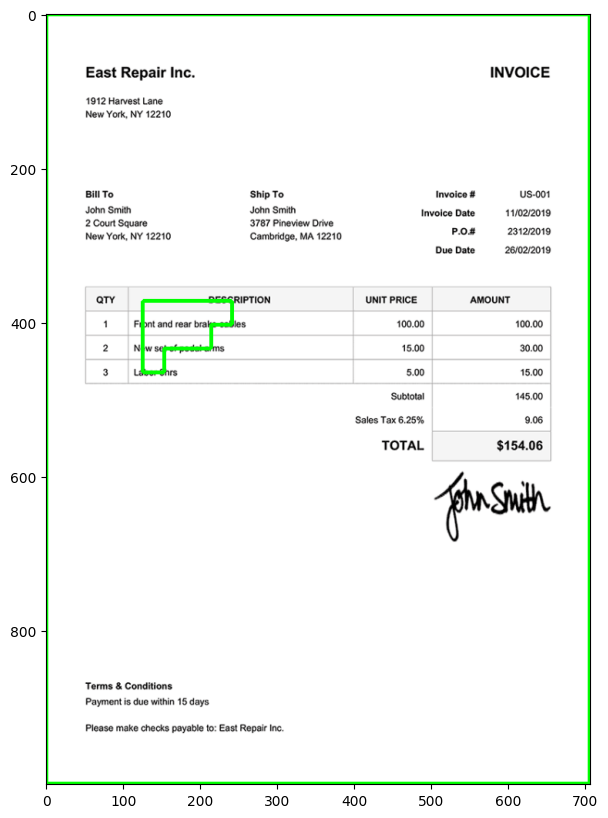

In [13]:
#detecting edges as well as the image part(if any)
contours, hierarchy = cv2.findContours(b_w_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
rgb_conv(image_with_contours)

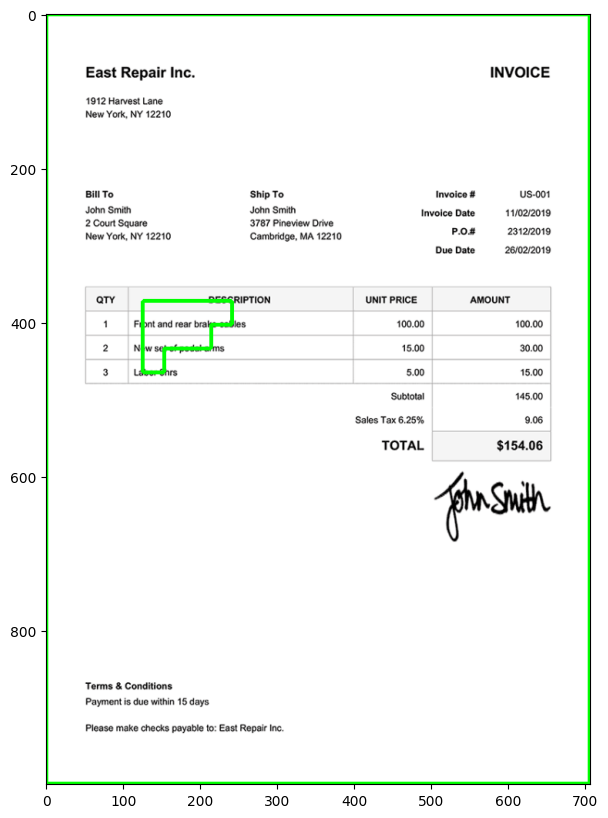

In [14]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
largest_contours_image = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
rgb_conv(largest_contours_image)

In [15]:
def app_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [16]:
def get_contour(bbox):
    for c in bbox:
        approx = app_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

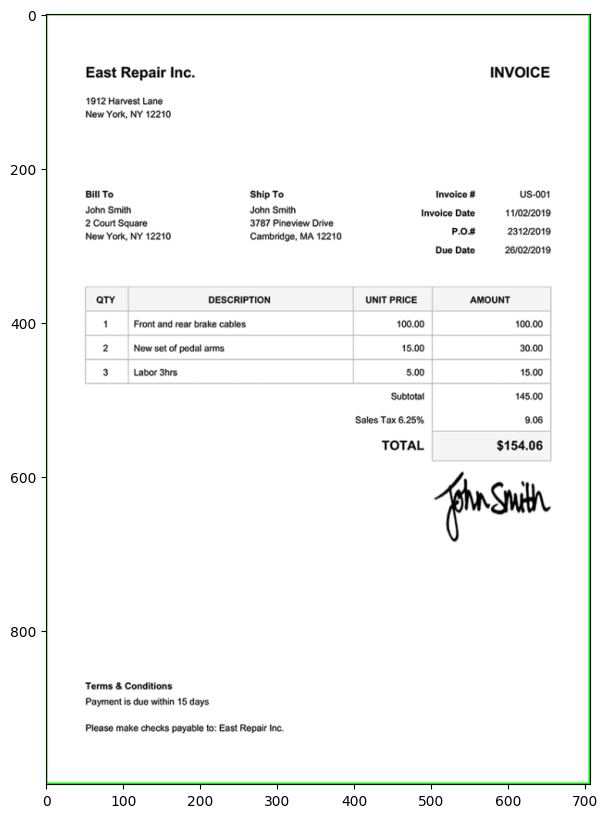

In [17]:
receipt_contour = get_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
rgb_conv(image_with_receipt_contour)

In [18]:
def rect_contour(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [19]:
def wrap_perspective(img, rect):
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

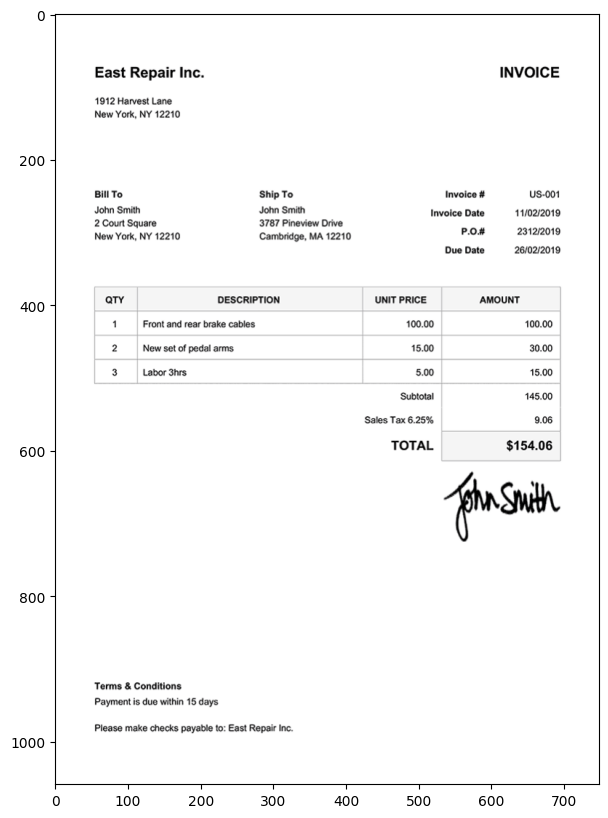

In [20]:
scanned = wrap_perspective(original.copy(), rect_contour(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

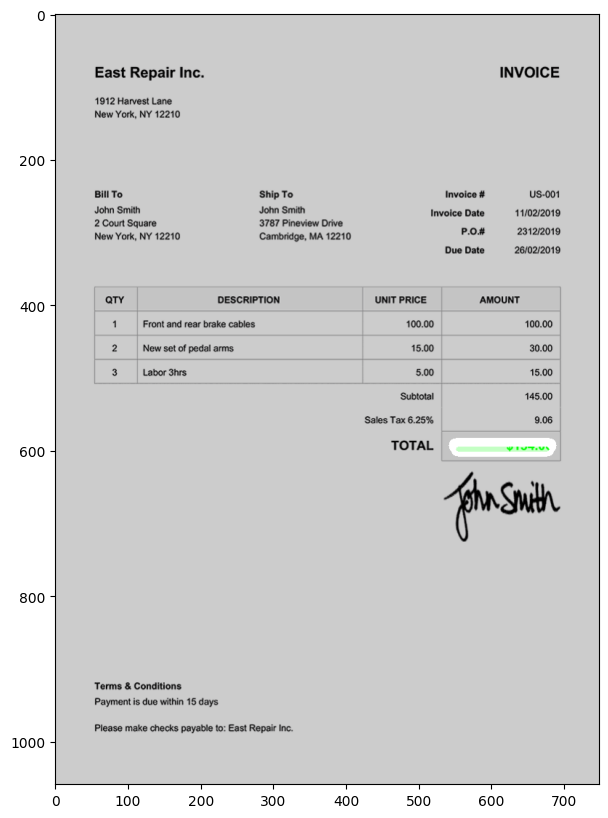

In [22]:
#do the process again recursively
temprature_image = cv2.cvtColor(scanned.copy(), cv2.COLOR_BGR2RGB)
blur = cv2.GaussianBlur(temprature_image, (5, 5), 1)
blur = cv2.medianBlur(blur,7)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
erosion = cv2.erode(blur,kernel,iterations = 1)
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 20))
dilated = cv2.dilate(erosion, rectKernel)


opening = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, rectKernel2)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, rectKernel2)
edged = cv2.Canny(opening, 30, 30, apertureSize=3)
rho = 1 
theta = np.pi / 600  
threshold = 10  
min_line_length = 50 
max_line_gap = 20  
line_image = np.copy(temprature_image) * 0  
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edged, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),20)
        diff_x = abs(x1 - x2)
        diff_y = abs(y1 - y2)
        if(diff_y <= diff_x):
            cv2.line(line_image,(x1,y1),(x2,y1),(0,255,0),5)
        else:
            cv2.line(line_image,(x1,y1),(x1,y2),(0,0,255),5)
        lines_edges = cv2.addWeighted(temprature_image, 0.8, line_image, 1, 0)


rgb_conv(lines_edges)

In [23]:
def conv_bw(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

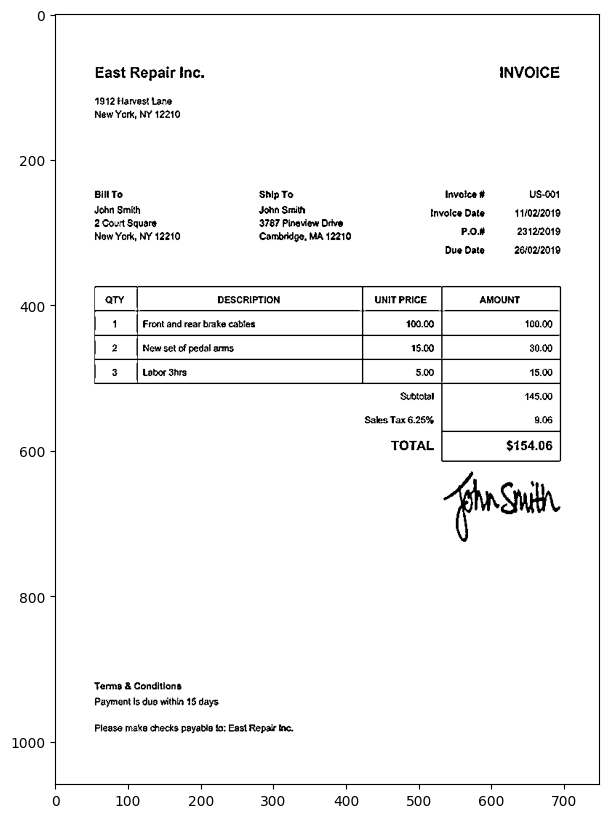

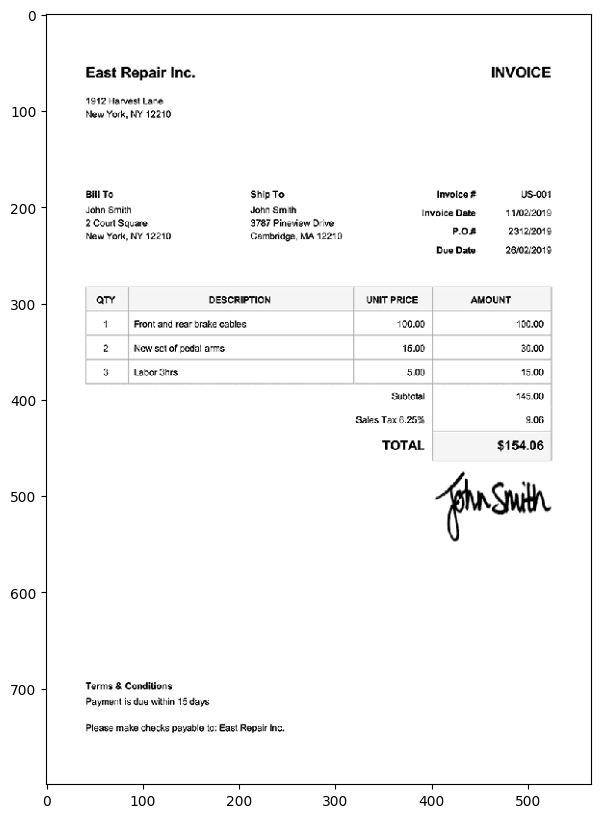

In [24]:
result = conv_bw(scanned)
grey_conv(result)
grey_conv(img)

In [25]:
#save the output into images folder
output = Image.fromarray(result)
output.save('/teamspace/studios/this_studio/images/result_final.png')